In [13]:
## Import packages

# basic
import pandas as pd
import numpy as np
import gower
import pickle
from datetime import date
from math import prod

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud

# text processing
from collections import Counter
from sklearn.feature_extraction import _stop_words
import string
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup

# numeric processing 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# modelling 
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import catboost
# 7 popular regression models
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge, SGDRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
# validation metrics 
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score

# Interpretability
import shap
from lime.lime_tabular import LimeTabularExplainer

# For sentiment analysis 
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/carolinesofieljorring/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/carolinesofieljorring/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/carolinesofieljorring/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Technical report 

## Introduction 
In this project, we would like to make recommendations to Amazon in order to improve their products and thereby their sales. The aim is to identify features related with high rated products which Amazon can use on low rated products. The category of products we will be investigating is Grocery and Gourmet Foods. We use two datasets for the analysis. One dataset with the ratings of the products and one dataset containing metadata of the products. 

The rating dataset contains all ratings of each product. The rating data is of dimension 5074160 x 4 and contains the following variables: 'item', 'user', 'rating', 'timestamp'. 

The metadata dataset contains information of the products. Thus the dataset contains one row per product. The metadatset is of dimension 287051 x 10 with the following variables: 'category', 'description', 'title', 'also_buy', 'brand', 'feature', 'rank', 'also_view', 'price', 'asin'. 

To analyze what features gives high ratings, we will build a regression model with average rating as response and product features as explanatory variables. One of the interesting explanatory variables is production "description" which we will use to to extract key feautures of the products using LDA (topic modelling). The model will then be analysed through feature importance to see which topics are describing high rated products.  

## Data preparation
Data and preprocessing:
In this project we will use two datasets. The first dataset contains ratings for groceries and gourmet foods and the second contains relevant information of the products. Both datasets are loaded with a function we call "CreateData". 

In [2]:
### Import raw data
def load_data(rating_filepath, review_filepath, metadata_filepath):
    ratings_df = pd.read_csv(rating_filepath, names = ['item','user','rating','timestamp'])
    reviews_df = pd.read_json(review_filepath, lines=True)
    metadata_df = pd.read_json(metadata_filepath, lines=True)
    return ratings_df, reviews_df, metadata_df

Then a preparation of the data is performed with the function "prepare_data". The purpose of this function is to merge the datasets and to structure the data. In the function we group on each item and we find the average rating, standard deviation of rating and the number of ratings for each item. 
The "category" feature is originally a list of categories with "Grocery and Gourmet Food" as the first element followed by multiple subcategories. Hence we change "category" so it only contains the second element of the list corresponding to the largest subcategory after the main category "Grocery and Gourmet Food".

In [2]:
### Function for preparing the data
def prepare_data(ratings_df, reviews_df, metadata_df):
    # create timestamps
    ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], origin = 'unix', unit = 's')
    reviews_df['timestamp'] = pd.to_datetime(reviews_df['unixReviewTime'], origin = 'unix', unit = 's')
    metadata_df['timestamp'] = pd.to_datetime(metadata_df['date'].apply(str), format = '%B %d, %Y', errors='coerce')

    # drop columns in reviews
    reviews_df = reviews_df.drop(columns=['unixReviewTime','reviewTime','reviewerName','vote','image','style','verified'])

    # drop columns in metadata
    metadata_df = metadata_df.drop(columns=['imageURL','imageURLHighRes'])
    
    # drop na's and duplicates
    reviews_df = reviews_df.dropna()
    reviews_df = reviews_df.drop_duplicates(keep='first')
    ratings_df = ratings_df.drop_duplicates(keep='first')

    # group ratings_df and merge with metadata, so there is one dataframe with both ratings and information of products
    grouped_ratings = ratings_df[['item','rating']].groupby(by='item').agg({'rating':['mean','std'],'item':'size'}).rename(columns={'statistics':'avg_rating','item':'num_ratings'}).reset_index()
    grouped_ratings.columns = ['_'.join(col).strip() if col[1] else col[0] for col in grouped_ratings.columns.values]
    grouped_ratings = grouped_ratings.rename(columns = {'rating_mean':'avg_rating','rating_std':'std_rating','num_ratings_size':'num_ratings'})
    metadata_df = grouped_ratings.merge(metadata_df, how='outer', left_on='item', right_on='asin')
    metadata_df['item'].fillna(metadata_df['asin'], inplace=True)
    metadata_df = metadata_df.drop(columns=['asin','date','tech1','tech2','fit'])

    # preprocess price
    metadata_df['price'] =  pd.to_numeric(metadata_df['price'].str.replace('$',''), errors='coerce')

    # Fill nan with empty space and use the get_category function
    metadata_df['category'] = metadata_df['category'].fillna('')
    metadata_df['category'] = metadata_df['category'].apply(get_category)
    
    return reviews_df, metadata_df

# Function to return only the first name in each category variable.
def get_category(row):
    if len(row) > 1:
        category = row[1]
    else:
        category = row
    return category


After the data is merged we save it as a new csv file.

In [4]:
rating_filepath = 'raw_data/Grocery_and_Gourmet_Food.csv'
review_filepath = 'raw_data/Grocery_and_Gourmet_Food_5.json' 
metadata_filepath = 'raw_data/meta_Grocery_and_Gourmet_Food.json'

raw_ratings, raw_reviews, raw_metadata = load_data(rating_filepath=rating_filepath, review_filepath=review_filepath, metadata_filepath=metadata_filepath)

reviews_df, metadata_df = prepare_data(raw_ratings, raw_reviews, raw_metadata)

# Save the new dataframes to later use. 
reviews_df.to_csv('data/reviews_df.csv',index=False)
metadata_df.to_csv('data/metadata_df.csv',index=False)

## Data Exploration
The idea behind our investigation is to find features of high rated products and recommend to add the features to low rated products. However, if the products are too different like chocolate and apples it does not make sense to compare features for these products even if one has a high rating and the other a low rating. Therefore, we analyze the data by looking at the different product categories and explore the number of products, the number of ratings and variance in the average rating of the products. It is important for our analysis that we have categories with both many products and many ratings. However it is also important that we have something to improve, meaning we need categories with some variances in the average rating of products. We will only be looking at the top 20 categories in the exploration. 

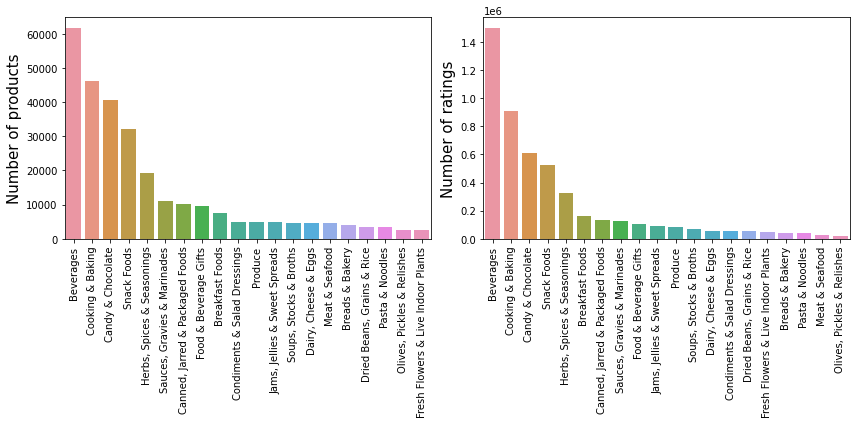

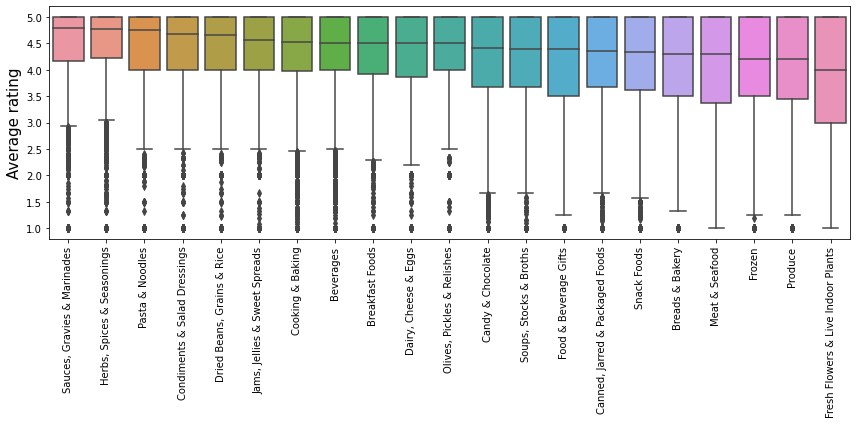

In [5]:
# load data 
df = pd.read_csv('data/metadata_df.csv')

# Number of products in each category
def get_category(row, categories):
    if row in categories:
        return row
    else:
        return ''

# We will only look at the top 20 categories
top = 20
categories = df['category'].value_counts().sort_values(ascending=False).index[0:top].to_list()

# Copy the dataframe
df_category = df.copy(deep=True)

# Return number of products in each category
df_category['category'] = df_category['category'].apply(lambda row: get_category(row, categories))
df_category = df_category[df_category['category'] != '']

# Number of ratings in each category
df_num_ratings = df[['category','num_ratings']].groupby(by=["category"]).sum(["num_ratings"])
df_num_ratings = df_num_ratings['num_ratings'].sort_values(ascending=False).reset_index()

# Plot of the number of productts in each category and the number of ratings in each category
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(12,6))
sns.countplot(x="category", data=df_category, order=categories, ax=ax1)
ax1.set_ylabel('Number of products', fontsize=15)
ax1.set_xlabel('')
ax1.set_xticklabels(categories,rotation=90)
sns.barplot(x="category", y="num_ratings", data=df_num_ratings[0:top], ax=ax2)
ax2.set_ylabel('Number of ratings', fontsize=15)
ax2.set_xlabel('')
ax2.set_xticklabels(df_num_ratings.loc[0:(top-1),'category'].to_list(),rotation=90)
fig.tight_layout()
fig.show()

# Plot with variance of average ratings in each category 
categories_union = list(set().union(categories,df_num_ratings.loc[0:top,'category'])) # list of categories shown in figure 1 and 2
df_mean_avg_rating = df[df['category'].isin(categories_union)].groupby('category').median(['avg_rating']).sort_values(by='avg_rating',ascending=False)
categories_union = df_mean_avg_rating.index.to_list()
plt.figure(2, figsize=(12,6))
sns.boxplot(x = 'category', y = 'avg_rating', data = df[df['category'].isin(categories_union)], order = categories_union)
plt.xticks(rotation=90)
plt.ylabel('Average rating', fontsize=15)
plt.xlabel('')
plt.tight_layout()
plt.show()

By investigating the plot with number of ratings and number of products we find "Beverages", "Cooking & Baking", "Candy & Chocolate" and "Snack Foods" are the categories with most in both. When we compare these categories with the boxplot showing the variance of the average rating, both "Snack Foods" and "Candy & Chocolate" have a decent spread. "Beverages" and "Cooking & Baking" almost have the same median and spread, but "Beverages" has both more products and ratings and we therefore only use "Beverages" as a category along with "Candy & Chocolate" and "Snack Foods". 

These three categories are then saved as csv file separetily. 

In [6]:
# Select category 
category = 'Candy & Chocolate'
df_cat = df[df['category']==category]

# Save dataframe for category 
df_cat.to_csv('data/'+category+'/df_'+category+'.csv',index=False)

## Data preprocessing
So far we have found 3 categories we want to use for our hypothesis and saved them as separate dataframes. These 3 datasets needs to be further processed before we can use them for modelling. In the function "preprocess_price" we are splitting our datasets into a training set and a test set. A lot of products in the three catgories are missing price. To overcome this issue and still be able to use price as a feature in the modelling, the missing price values in each category are replaced with the average price of the category.

In [7]:
# Function for preprocessing the prize where the data also will splitted in a train and a test set. 
def preprocess_price(metadata_df):
    # Drop columns we don't use
    df = metadata_df.drop(columns = ['item','title','feature','main_cat','similar_item','details','timestamp'])
    # Empty columns can't be used for anything
    df = df.dropna(axis=0,subset=['avg_rating','num_ratings','description'])
    # Split the data in a 75 % split train and test set. 
    df_train, df_test = train_test_split(df, train_size=0.75)

    # Below we find the mean price for every cateogry. 
    categories = []
    category_means = []
    categories = df_train.category.unique()
    for i in categories:
        temp = df_train[df_train['price'].isna() == False]
        mean_value = temp[temp['category'] == i]['price'].mean()
        category_means.append(mean_value)
    dict = {'categories': categories,'category_means': category_means}
    category_stat_df = pd.DataFrame(dict)
    category_stat_df = category_stat_df.set_index('categories')

    # Next for all NULL values we assign the price to be the mean price in that category.
    df_train['price'] = df_train.apply(lambda row: category_stat_df.loc[row['category']].values[0] if row['price'] != row['price'] else row['price'], axis = 1)
    df_test['price'] = df_test.apply(lambda row: category_stat_df.loc[row['category']].values[0] if row['price'] != row['price'] else row['price'], axis = 1)
    
    # Here we drop the category column. 
    columns = df_train.columns
    if 'category' in columns:
        df_train = df_train.drop(columns = ['category'])
        df_test = df_test.drop(columns = ['category'])
    if 'orig category' in columns:
        df_train = df_train.drop(columns = ['orig category'])
        df_test = df_test.drop(columns = ['orig category'])
    return df_train, df_test

The training set and the test set are now further processed in the "preprocess_data" function where the features are cleaned and prepared for modelling. 

In the function we clean the features "also_buy", "also_view", "rank" and "description". For each product, the two features "also_buy" and "also_view" contain a list of other products that are often bought or viewed together with the product. These features are converted to a count. For the feature "rank", which contains the sales rank information of the products, all characters are removed besides the sales rank number which is converted to an integer value. 

In the "description" feauture we clean text from html code, remove punctuation and stop words etc. When removing stop words from "description" we only use the English stop words. However when we later on perform LDA on the data we observe there are words that either occur in multiple topics or doesn't make sense in the topic, and therefore we add them to stop words for the specific category. 

In [4]:
# Function to preprocess the train and test dataset
def preprocess_data(df_train, df_test):
    # get number of also_buy
    df_train['also_buy'] = df_train['also_buy'].fillna('').apply(get_number_also_buy)
    df_test['also_buy'] = df_test['also_buy'].fillna('').apply(get_number_also_buy)

    # get number of also_view
    df_train['also_view'] = df_train['also_view'].fillna('').apply(get_number_also_buy)
    df_test['also_view'] = df_test['also_view'].fillna('').apply(get_number_also_buy)

    # sales rank information
    df_train['rank'] = df_train['rank'].apply(get_rank).str.replace(',','').str.extract('(\d+|$)')
    df_train['rank'] = pd.to_numeric(df_train['rank'], errors = 'coerce').fillna(0).apply(int)
    df_test['rank'] = df_test['rank'].apply(get_rank).str.replace(',','').str.extract('(\d+|$)')
    df_test['rank'] = pd.to_numeric(df_test['rank'], errors = 'coerce').fillna(0).apply(int)

    # Clean description
    df_train['description'] = df_train['description'].apply(get_description)
    # Drop rows with no information
    df_train = df_train.dropna(axis = 0, subset=['description'])
    # Make it a string and clean html text
    df_train['description'] = df_train['description'].apply(str)
    df_train['description'] = df_train['description'].str.replace('\n', '')
    df_train['description'] = df_train[['description']].applymap(lambda text: BeautifulSoup(text, 'html.parser').get_text())
    # Perform text processing where stop words are removed etc. 
    df_train['description'] = df_train['description'].apply(text_processing)

    # Do the same for test dataset
    df_test['description'] = df_test['description'].apply(get_description)
    df_test = df_test.dropna(axis = 0, subset=['description'])
    df_test['description'] = df_test['description'].apply(str)
    df_test['description'] = df_test['description'].str.replace('\n', '')
    df_test['description'] = df_test[['description']].applymap(lambda text: BeautifulSoup(text, 'html.parser').get_text())
    df_test['description'] = df_test['description'].apply(text_processing)
    return df_train, df_test
    
# Number of also bougtht products
def get_number_also_buy(row):
    number = len(row)
    return number
# Get the brand
def get_brand(row, brands):
    if row in brands:
        return row
    else:
        return 'Other'
# Get the rank from list
def get_rank(row):
    if isinstance(row, list):
        if len(row) > 0:
            return row[0]
        else:
            return ''
    else:
        return row

# Use only rows with list of information else nan
def get_description(row):
    if isinstance(row, list):
        if len(row)>0:
            return row
        else:
            return np.nan
    else:
        return row

# Function used to clean text data
def text_processing(text):
    # remove punctuation 
    text = "".join([c for c in text 
        if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    # stemming / lematizing (optional)
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    # remove stopwords
    text = " ".join([w for w in text.split() 
        if w not in Stop_Words])
    return text
    # Words from already trained lda model. The words are removed because they either occur in multiple topics or doesn't make sense in the topic. 

category = 'Candy & Chocolate'
if category == 'Candy & Chocolate':
    Stop_Words = _stop_words.ENGLISH_STOP_WORDS.union(['chocolate','supplement','cocoa','candy','cure','condition'])
elif category == 'Snack Foods':
    Stop_Words = _stop_words.ENGLISH_STOP_WORDS.union(['snack','food','fda','flavor','product','ingredient','statement'])
elif category == 'Beverages':
    Stop_Words = _stop_words.ENGLISH_STOP_WORDS.union(['tea','coffee','water','cup','supplement','flavor','year','food','condition'])

The training and test set are now almost fully processed, but we still need to handle categorical data. The "brand" feature contains almost 15000 different brands and it would not make any sense to one-hot-encode a feature with this many unique values, as we would get an enourmus dataset. We will therefore perform a principle components analysis in order to decompose this data. 
Calculating the variance explained by the components in the new space, we found that two components was sufficiant to explain 99% 
of the variance. Using these two components describing the new space of the data, we defined 5 clusters in the data using the K-means algorithm. We hope that enough information about the brands are stored in the decomposition and through that in the clusters, that we will carry some of this informations over in the new dataset through the clusters, that we can use the brands to model our target variable, without one-hot-encoding the approximately 15000 brands. 

Finnaly we assign the clusters to the preprocessed data and one-hot-encode it, before saving the new dataset which is to be used for modelling.

In [9]:
# First we read the "prepared" data and the proper category found in the "exploratory part"
metadata_df = pd.read_csv('data/'+category+'/df_'+category+'.csv')

#We clone the category, as we will need this in order to preprocess price, but we will remove the original category column, 
# when we create dummy data
metadata_df['orig category'] = metadata_df['category']
dummy_df = pd.get_dummies(metadata_df, columns=['brand','orig category'])
# We drop brand as we can't have non numerical values. 
metadata_df = metadata_df.drop(columns=['brand'])

# We apply the preprocess price function, which handles some of the preprocess functions as well as splits the data in train and test.
df_train, df_test = preprocess_price(metadata_df)
df_train_dummy, df_test_dummy = preprocess_price(dummy_df)

# Next the second part of the preprocess will be applied.
df_train, df_test = preprocess_data(df_train, df_test)
df_train_dummy, df_test_dummy = preprocess_data(df_train_dummy, df_test_dummy)

## We drop description when we do pca on the data as it is non-numerical. Also we drop std_rating as it is quite hightly correlated with 
# Avg. rating, and it seems unlikely that std_rating can be gathered in a situation where average rating (the target) can't.
df_train_dummy = df_train_dummy.drop(columns = ['description','std_rating'])
df_test_dummy = df_test_dummy.drop(columns = ['description','std_rating'])

## Next we decompose our data.
pca = PCA(n_components=100)
pca.fit(df_train_dummy)
#print(pca.explained_variance_ratio_)

## The explained variance have been calculated, and it seems only 2 components are neccesary.
pca = PCA(n_components=2).fit(df_train_dummy)
pca_values = pca.fit_transform(df_train_dummy)

## Then we create 5 clusters using KMeans.
kmeans = KMeans(n_clusters=5).fit(pca_values)

## We assign these clusters to our original (preprocessed) data.
df_train['cluster'] = kmeans.labels_
pca_values_test = pca.transform(df_test_dummy)
df_test['cluster'] = kmeans.predict(pca_values_test)

## We one hot encode the clusters, so that any model trained on the data, won't assume there is a relationship, between the values.
df_train = pd.get_dummies(df_train, columns = ['cluster'])
df_test = pd.get_dummies(df_test, columns = ['cluster'])

# ensure same shape of train and test
if df_train.shape[1] != df_test.shape[1]:
    setdiff = set(df_train.columns).difference(set(df_test.columns))
    for name in setdiff:
        df_test[name] = np.zeros(df_test.shape[0])
        df_test = df_test.astype({name:'int'})

# order columns in test set
df_test = df_test[df_train.columns]  

We save the training and test set as csv files, since these datasets are now ready for modelling except for the feature "description" which we will perform LDA on in the next step.

In [13]:
df_train.to_csv('data/' + category + '/df_train.csv',index=False)
df_test.to_csv('data/' + category + '/df_test.csv',index=False)

## LDA Modeling
After the preprocessing of the feature "description", we will now make a last "pre-process" step in order to make every single feature numeric. We will decompose the product descriptions using the Latent Dirichlet Allocation to find topics - hopefully containing key product features. 

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Model's Params:  {'learning_decay': 0.8, 'n_components': 2}


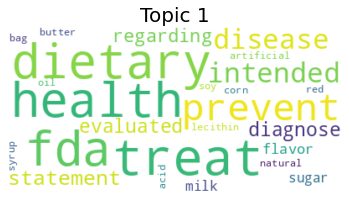

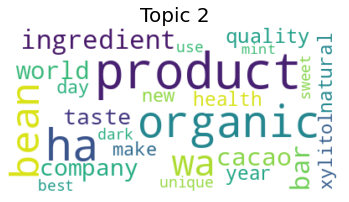

In [14]:
# set random seed
np.random.seed(42)

#%% Functions 
def get_len(text):
    if text != text:
        return 0
    elif isinstance(text, float):
        return 1
    else:
        return len(text)

# Function where LDA is trained on both the trainf and test. Both datasets are returned along with the model and count_vect
def train_lda(df_train, df_test, n_topics, ld, text):

    count_vect = CountVectorizer()
    bow_counts_train = count_vect.fit_transform(df_train[text].values)
    bow_counts_test = count_vect.transform(df_test[text].values)

    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                learning_decay=ld)

    X_train_lda = lda.fit_transform(bow_counts_train)
    X_test_lda = lda.transform(bow_counts_test)

    return X_train_lda, X_test_lda, lda, count_vect


# Function to print the top words in a topic
def print_top_words(model, feature_names, n_top_words):
    norm = model.components_.sum(axis=1)[:, np.newaxis]
    for topic_idx, topic in enumerate(model.components_):
        print(80 * "-")
        print("Topic {}".format(topic_idx))
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            print("{:.3f}".format(topic[i] / norm[topic_idx][0]) 
                  + '\t' + feature_names[i])

# Function to visualize the topics in a wordcloud
def visualize_topics(lda, count_vect, terms_count):
    terms = count_vect.get_feature_names()
    for idx, topic in enumerate(lda.components_):
        title = 'Topic ' + str(idx+1)
        abs_topic = abs(topic)
        topic_terms = [[terms[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
        topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
        topic_words = []
        for i in range(terms_count):
            topic_words.append(topic_terms_sorted[i][0])
            # print(','.join( word for word in topic_words))
            # print("")
            dict_word_frequency = {}
        for i in range(terms_count):
            dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]
            wcloud = wordcloud.WordCloud(background_color="white",mask=None, max_words=100,\
            max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
            contour_width=3,contour_color='black')
            wcloud.generate_from_frequencies(dict_word_frequency)
        plt.imshow(wcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(title, fontsize=20)
        # plt.savefig("Topic#"+str(idx+1), format="png")
        plt.show()
    return

# Get data 
category = 'Candy & Chocolate'
train_path = 'data/' + category + '/df_train.csv'
test_path = 'data/' + category + '/df_test.csv'
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# RUN LDA
df_train = df_train.dropna(axis=0,subset=['description'])
df_test = df_test.dropna(axis=0,subset=['description'])

# Options to tune hyperparamets in LDA model
# Beware it will try *all* of the combinations, so it'll take ages
search_params = {'n_components': [2, 3, 4], 'learning_decay': [.6, .7, .8]}

# Set up LDA with the options we'll keep static
model = LatentDirichletAllocation(learning_method='online',
                                  max_iter=5,
                                  random_state=0)

# Try all of the options
gridsearch = GridSearchCV(model,
                          param_grid=search_params,
                          n_jobs=-1,
                          verbose=1)
count_vect = CountVectorizer()
cv_matrix = count_vect.fit_transform(df_train['description'].values)
gridsearch.fit(cv_matrix)

## Save the best model
best_lda = gridsearch.best_estimator_

# What did we find?
print("Best Model's Params: ", gridsearch.best_params_)

# Train LDA with best params
n_topics = gridsearch.best_params_['n_components']
learning_decay = gridsearch.best_params_['learning_decay']

# Run LDA on description with tuned parameters
X_train_lda, X_test_lda, lda, count_vect = train_lda(df_train, df_test, n_topics, learning_decay, 'description')

# Visualize topics as wordclouds
visualize_topics(lda, count_vect, 25)

# Merge df with lda 
lda_list = []
for i in range(n_topics):
    lda_list.append('lda'+str(i+1))
X_train_lda_df = pd.DataFrame(X_train_lda, columns = lda_list)
X_test_lda_df = pd.DataFrame(X_test_lda, columns = lda_list)
df_train_lda = df_train.merge(X_train_lda_df, left_index=True, right_index=True)
df_test_lda = df_test.merge(X_test_lda_df, left_index=True, right_index=True)

# Save merged data + model
today = date.today()
df_train_lda.to_csv('data/' + category + '/df_train_lda.csv',index=False)
df_test_lda.to_csv('data/' + category + '/df_test_lda.csv',index=False)
filename = 'models/'+category+'/lda_model_'+str(today)+'.sav'
pickle.dump(lda, open(filename, 'wb'))
filename = 'models/'+category+'/count_vect_model_'+str(today)+'.sav'
pickle.dump(count_vect, open(filename, 'wb'))

We can conclude, that for our dataset, it is the most effecient, to have a few broad topics. This may also make sence, as our data have already been categorised into smaller datasets being Chocolate & Candy, Beverages and Snack Foods. Maybe if we hadn't already made a subset of the food dataset more topics would have been necessary, in order to create the best Topic modeling. The LDA values have been concatenated with the preprocessed dataframe, so every data transformation done so far can be combined and used with a regression model, in order to make good predictions. 

The final LDA model was found by making a parameter grid of possible hyperparameters, where we used cross validation to find the best combination.

For each category, the top 25 words are plotted using a wordcloud plot. Words being replicated in multiple topics or words irrelevant for product recommendations are added to stopwords and the LDA is run again to create topics of higher quality. 

## Exploratory analysis post data preprocessing and LDA
Next we had to go back and look at the data using plots - more specificly boxplots and quantiles. We wanted to find a product which had a lot of sales, but a low average rating, as we thought we could use our analysis of the descriptions of the products to enchance a product, which could be made into a formal recommendation sold to Amazon. The code to find this product can be seen below:

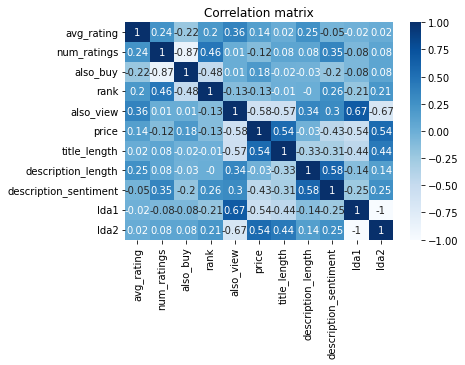

The indexes of the 200 best rated products:  [3624, 5512, 2431, 2437, 2441, 5514, 2444, 2446, 5513, 2448, 2450, 5511, 5524, 5506, 2455, 2456, 2457, 5505, 2461, 5503, 2464, 5501, 2430, 2427, 2469, 5535, 2390, 2393, 2394, 2395, 2396, 2397, 2399, 5546, 2404, 2411, 2425, 2412, 2414, 2415, 2417, 2420, 5528, 2422, 2423, 5527, 2468, 2470, 5558, 5460, 2522, 2523, 5464, 2525, 5463, 2527, 2528, 2529, 2533, 2535, 2520, 5459, 5458, 5455, 5451, 5449, 2545, 2548, 5448, 5447, 5465, 5467, 2474, 2497, 2475, 2477, 2478, 5495, 5494, 2487, 2488, 2491, 2493, 5480, 2518, 5477, 2501, 2502, 2503, 2504, 5475, 5474, 5473, 2511, 5553, 5563, 2555, 2271, 2251, 2252, 5657, 5656, 5650, 2266, 2267, 5645, 5644, 5639, 5663, 2280, 2283, 5633, 2291, 2292, 2293, 5625, 2295, 5624, 2250, 2247, 5619, 2229, 2217, 5684, 2219, 5682, 2222, 5680, 2225, 2227, 2228, 5677, 5664, 2231, 2232, 5673, 5668, 2239, 5666, 2241, 2242, 2244, 5623, 2305, 2385, 5574, 5578, 2354, 2355, 2356, 2358, 5577, 5576, 2364, 2366, 2370, 2347, 5568, 2375, 

In [33]:
## Define the category to investigate
category = 'Candy & Chocolate'

##Load data
df_test = pd.read_csv('data/'+category+'/df_test_lda.csv')

## Drop description as we assume we have gotten the most out of this variable using LDA.
df_test = df_test.drop(columns=['description'])

### find the right product to enchance

## We find subsets of the data, to limit the amount of products to check.

## Finding the 75% quantile of number of ratings
df_test['rank'].describe()

## Defining that subset
products_to_enhance = df_test[df_test['rank']<=df_test['rank'].describe().loc['25%']]

products_to_enhance['num_ratings'].describe()

## Finding the 75% quantile of the 75% quantile of the number of ratings
products_to_enhance = products_to_enhance[products_to_enhance['num_ratings']>=products_to_enhance['num_ratings'].describe().loc['75%']]


products_to_enhance['avg_rating'].describe()

## Finding the 25% quantile of avg. ratings of the subset.

products_to_enhance = products_to_enhance[products_to_enhance['avg_rating'] <= df_test['avg_rating'].describe().loc['25%'] ]

products_to_enhance['rank'].describe()

## finding the 75% quantile of number of ratings from the subset
products_to_enhance = products_to_enhance[products_to_enhance['rank']<=products_to_enhance['rank'].describe().loc['25%']]

#products_to_enhance['std_rating'].describe()
## Finding the 25% quantile of standard deviations for ratings in the subset
#products_to_enhance = products_to_enhance[products_to_enhance['std_rating'] <= products_to_enhance['std_rating'].describe().loc['25%'] ]

#products_to_enhance = products_to_enhance[products_to_enhance['rank'] <= products_to_enhance['rank'].describe().loc['75%'] ]

product_to_enhance = products_to_enhance.loc[products_to_enhance['rank'] == min(products_to_enhance['rank'])]

sns.heatmap(products_to_enhance.corr().round(2), cmap='Blues', annot=True)\
   .set_title('Correlation matrix')
plt.show()


## Find the 200 best rated products

indexes = df_test['avg_rating'].sort_values(ascending=False)[0:199].index.to_list()

print("The indexes of the 200 best rated products: ",indexes)

We have found a product which could be interesting to enchance (product with index 1311). Also we found the indexes of the best 200 rated products. We will use these indexes, when we later will try and interpret the descisioning from our regression model. This will help us find the most important features, which customers values when chosing a product to buy.

## Building regression models 

After preprocessing data and applying LDA on "description", we are ready to build a regression model with average rating as response and the explanatory variables: the number of often bought products, the number of often viewed products, sales rank, price, description topics and brand clusters. 

The function "train_regression_models" fits 7 different regression models to the training data and returns the model that performs best on the test data in terms of mean absolute error (MAE). 

In [16]:
# set random seed
np.random.seed(42)

# load preproccesed + lda data and select specific category 
category = 'Snack Foods'
df_train = pd.read_csv('data/' + category + '/df_train_lda.csv')
df_test = pd.read_csv('data/' + category + '/df_test_lda.csv')

df_train = df_train.drop(columns=['description','std_rating'])
df_test = df_test.drop(columns=['description','std_rating'])
df_train = df_train.dropna()
df_test = df_test.dropna()

# prepare for training
y_train = df_train['avg_rating']
y_test = df_test['avg_rating']
X_train = df_train.drop(columns=['avg_rating'])
X_test = df_test.drop(columns=['avg_rating'])

# Function to train 7 regression models
def train_regression_models(X_train, X_test, y_train, y_test):
    # Linear Regression
    linear_regression = LinearRegression().fit(X_train, y_train)
    y_linear_regression = linear_regression.predict(X_test)
    MAE_linear_regression = mean_absolute_error(y_test, y_linear_regression)
    r2_linear_regression = r2_score(y_test, y_linear_regression)
    var_linear_regression = explained_variance_score(y_test, y_linear_regression)
    print("----------------------")
    print("Linear Regression: ")
    print("MAE ", MAE_linear_regression)
    print("R2 ", r2_linear_regression)
    print("Explained variance ", var_linear_regression)
    print("----------------------")

    # XGBoost Regressor
    xgb_regressor = XGBRegressor().fit(X_train, y_train)
    y_xgb_regressor = xgb_regressor.predict(X_test)
    MAE_xgb_regressor = mean_absolute_error(y_test, y_xgb_regressor)
    r2_xgb_regressor = r2_score(y_test, y_xgb_regressor)
    var_xgb_regressor = explained_variance_score(y_test, y_xgb_regressor)
    print("----------------------")
    print("XGBoost Regressor: ")
    print("MAE ", MAE_xgb_regressor)
    print("R2 ", r2_xgb_regressor)
    print("Explained variance ", var_xgb_regressor)
    print("----------------------")

    # CatBoost Regressor
    catboost_regressor = CatBoostRegressor(allow_writing_files=False).fit(X_train, y_train, logging_level='Silent')
    y_catboost_regressor = catboost_regressor.predict(X_test)
    MAE_catboost_regressor = mean_absolute_error(y_test, y_catboost_regressor)
    r2_catboost_regressor = r2_score(y_test, y_catboost_regressor)
    var_catboost_regressor = explained_variance_score(y_test, y_catboost_regressor)
    print("----------------------")
    print("CatBoost Regressor: ")
    print("MAE ", MAE_catboost_regressor)
    print("R2 ", r2_catboost_regressor)
    print("Explained variance ", var_catboost_regressor)
    print("----------------------")

    # Stochastic Gradient Descent Regression
    sgd_regressor = SGDRegressor().fit(X_train, y_train)
    y_sgd_regressor = sgd_regressor.predict(X_test)
    MAE_sgd_regressor = mean_absolute_error(y_test, y_sgd_regressor)
    r2_sgd_regressor = r2_score(y_test, y_sgd_regressor)
    var_sgd_regressor = explained_variance_score(y_test, y_sgd_regressor)
    print("----------------------")
    print("Stochastic Gradient Descent Regression: ")
    print("MAE ", MAE_sgd_regressor)
    print("R2 ", r2_sgd_regressor)
    print("Explained variance ", var_sgd_regressor)
    print("----------------------")

    # Elastic Net Regression
    elastic_net = ElasticNet().fit(X_train, y_train)
    y_elastic_net = elastic_net.predict(X_test)
    MAE_elastic_net = mean_absolute_error(y_test, y_elastic_net)
    r2_elastic_net = r2_score(y_test, y_elastic_net)
    var_elastic_net = explained_variance_score(y_test, y_elastic_net)
    print("----------------------")
    print("Elastic Net Regression: ")
    print("MAE ", MAE_elastic_net)
    print("R2 ", r2_elastic_net)
    print("Explained variance ", var_elastic_net)
    print("----------------------")

    # Bayesian Ridge Regression
    bayesian_ridge = BayesianRidge().fit(X_train, y_train)
    y_bayesian_ridge = bayesian_ridge.predict(X_test)
    MAE_bayesian_ridge = mean_absolute_error(y_test, y_bayesian_ridge)
    r2_bayesian_ridge = r2_score(y_test, y_bayesian_ridge)
    var_bayesian_ridge = explained_variance_score(y_test, y_bayesian_ridge)
    print("----------------------")
    print("Bayesian Ridge Regression: ")
    print("MAE ", MAE_bayesian_ridge)
    print("R2 ", r2_bayesian_ridge)
    print("Explained variance ", var_bayesian_ridge)
    print("----------------------")

    # Gradient Boosting Regression
    gb_regressor = GradientBoostingRegressor().fit(X_train, y_train)
    y_gb_regressor = gb_regressor.predict(X_test)
    MAE_gb_regressor = mean_absolute_error(y_test, y_gb_regressor)
    r2_gb_regressor = r2_score(y_test, y_gb_regressor)
    var_gb_regressor = explained_variance_score(y_test, y_gb_regressor)
    print("----------------------")
    print("Gradient Boosting Regression: ")
    print("MAE ", MAE_gb_regressor)
    print("R2 ", r2_gb_regressor)
    print("Explained variance ", var_gb_regressor)
    print("----------------------")

    MAEs = [MAE_linear_regression, MAE_xgb_regressor, MAE_catboost_regressor, MAE_sgd_regressor,
            MAE_elastic_net, MAE_bayesian_ridge, MAE_gb_regressor]
    models = [linear_regression, xgb_regressor, catboost_regressor, sgd_regressor, elastic_net, 
            bayesian_ridge, gb_regressor]
    names = ['linear_regression', 'xgb_regressor', 'catboost_regressor', 'sgd_regressor', 'elastic_net', 
            'bayesian_ridge', 'gb_regressor']
    best_idx = np.argmin(MAEs)
    return models[best_idx], names[best_idx]

For all model runs, either catboost regressor or gradient boost regressor performed best. Thus we have created a function called "tune_model" that are tuning the hyperparatemers of these two regression models. The tuning of the models is cumbersome due to computation time, why we have chosen to keep the dimension of the parameter space low.  

In [33]:
# Function to tune the best model where the two best are catboost or gb_regressor
def tune_model(model, name, X_train, y_train):
        if name == 'catboost_regressor':
                # tune parameters of catboost
                parameters = {'depth' : [5, 10, 15],
                                'learning_rate' : [0.02, 0.03]}
                # Perform gridsearch with parameters
                Grid_CBC = GridSearchCV(estimator=model, param_grid=parameters, cv=5, n_jobs=-1, verbose=0)
                Grid_CBC.fit(X_train, y_train)
                depth = Grid_CBC.best_params_['depth']
                learning_rate = Grid_CBC.best_params_['learning_rate']
                catboost_regressor = CatBoostRegressor(allow_writing_files=False, depth=depth, learning_rate=learning_rate).fit(X_train, y_train, logging_level='Silent')
                regressor = catboost_regressor
                parameters = Grid_CBC.best_params_
        elif name == 'gb_regressor':
                # tune parameters of gradient boost regressor
                parameters = {'max_depth' : [5, 10, 15],
                                'learning_rate' : [0.02, 0.03]}
                Grid_GBR = GridSearchCV(estimator=model, param_grid=parameters, cv=5, n_jobs=-1, verbose=0)
                Grid_GBR.fit(X_train, y_train)
                depth = Grid_GBR.best_params_['depth']
                learning_rate = Grid_GBR.best_params_['learning_rate']
                gb_regressor = GradientBoostingRegressor(depth=depth, learning_rate=learning_rate).fit(X_train, y_train)
                regressor = gb_regressor
                parameters = Grid_GBR.best_params_
        return parameters, regressor  

# train and tune model
model, name = train_regression_models(X_train, X_test, y_train, y_test)
params, tuned_model = tune_model(model, name, X_train, y_train)

# validate model
predictions = tuned_model.predict(X_test)

print("The predictions using the best performing models are: ", predictions)
print("The true values are: ", y_test)
print("This gives the difference between predictions and true values: ", predictions-y_test)
print("The MAE of the model is: ", mean_absolute_error(y_test, predictions))

today = date.today()
# save model
filename = 'models/'+category+'/best_performing_model_'+str(today)+'.sav'
pickle.dump(model, open(filename, 'wb'))
# save tuned model
filename = 'models/'+category+'/tuned_'+name+'_'+str(today)+'.sav'
pickle.dump(tuned_model, open(filename, 'wb'))


The best models are saved, so we do not have to run the tuning again. 

## Interpretability of the models
After model tuning, we are ready to interpret the model to find out what features are important and how they relate to the product ratings. 


In [ ]:
category = 'Candy & Chocolate' # get category 

# load best model
today = date.today()
model = pd.read_pickle('models/'+category+'/best_performing_model_2022-05-03.sav') # catboost-regressor

# load data 
df_train = pd.read_csv('data/' + category + '/df_train_lda.csv')
df_test = pd.read_csv('data/' + category + '/df_test_lda.csv')
df_train = df_train.drop(columns=['description','std_rating'])
df_test = df_test.drop(columns=['description','std_rating'])
df_train = df_train.dropna()
df_test = df_test.dropna()
X_train = df_train.drop(columns='avg_rating')
y_train = df_train['avg_rating']
X_test = df_test.drop(columns='avg_rating')
y_test = df_test['avg_rating']

### Global interpretability
Here we interpret the model at a global scale. 

In [15]:
# Get shap values 
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(X_test)
shap_values_pandas = pd.DataFrame(shap_values)
print('The overall mean (expected value): ', explainer.expected_value)
shap_values_pandas.head()

Exception: Model type not yet supported by TreeExplainer: <class 'sklearn.decomposition._lda.LatentDirichletAllocation'>

The above matrix of dimension samples x number of features shows the shap values. The sum of each row gives the difference from the overall mean (the expected value). 

In [ ]:
# shap summary plots
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False, plot_size=None)
plt.subplot(1,2,2)
shap.summary_plot(shap_values, X_test, show=False, plot_size=None)
plt.tight_layout()
plt.show()

The above figures shows a summary of how the features impact the predictions. The right summary plot shows how the features impact the predictions and the left plot shows how the features impact the predictions in magnitude. 

From both plots, it is seen that the features with the highest impact on the average rating are sales rank and price. The lda topics 1 and 2 also have an impact, although of small magnitude. The clusers do not seem to have much impact on average rating and thus we could consider removing the clusters from the model. 

More anaylsis....

In [ ]:
# Partial dependence plot of relevant variables 
fig, axes = plt.subplots(1,3,figsize=(15,6))
shap.dependence_plot(ind='lda1', interaction_index='lda1',shap_values=shap_values, features=X_test, show=False, ax = axes[0])
shap.dependence_plot(ind='lda2', interaction_index='lda2',shap_values=shap_values, features=X_test, show=False, ax = axes[1])
shap.dependence_plot(ind='lda1', interaction_index='lda2',shap_values=shap_values, features=X_test, show=False, ax = axes[2])
plt.tight_layout()
plt.show()

Partial dependence plots. Shows shap values against feature. Also possible to look at two-ways interactions. 

In [ ]:
# shap force plot of 200 products with high ratings 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[indexes,:], X_test.iloc[indexes,:]) # use indexes from post exploratory

The above figure shows how the features impact on the predictions of the 200 products in the test data with highest rating. Blue feature values are lowering the prediction and red feature values are increasing the prediction value. 

### Local interpretability

Here we look at how the features influence the prediction of the product to enhance. 

In [ ]:
# Get index of porduct to enhance 
product_to_enhance = int(product_to_enhance.index.values) # 3260

# shap force plot
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[product_to_enhance,:], X_test.iloc[product_to_enhance,:])

In [ ]:
# lime explainer 
explainer = LimeTabularExplainer(X_test.values,mode='regression',feature_names = X_test.columns,discretize_continuous=True)

We have a LimeTabularExplainer because the data is in a dataframe. We use regression and discretize_continuous if True, all non-categorical features will be discretized into quartiles.

In [ ]:
exp = explainer.explain_instance(X_test.values[product_to_enhance], model.predict, num_features=5)
exp.show_in_notebook(show_all=False) 
# only the features used in the explanation are displayed

Here we have used the week 4 notebook to just explain the prediction with lowest error. Below we do the same for the prediction with the highest error.
We can give any index of a prediction and see how important each feature is. 
Maybe standardize some features. 

## Sales analysis 
Since we have come to the conclusion, that we are not able to give Amazon recommendations of how to improve their products in terms of product properties extracted from the product descriptions, we shift our focus to how the product descriptions affect sales. The question is if Amazon and their suppliers can do something with their product descriptions which could increase the number of sales of the product. 

Again we will analyse the Grocery and Gourmet Food category "Candy & Chocolate". 

In [101]:
# load data 
category = 'Candy & Chocolate' # define category 
metadata_df = pd.read_csv('data/'+category+'/df_'+category+'.csv')
print('Check category: ', metadata_df.category.unique())
# drop features not used for sales analysis
metadata_df = metadata_df.drop(columns = ['std_rating','category','brand','feature','main_cat','similar_item','details','timestamp'])

Check category:  ['Candy & Chocolate']


### Data preprocessing 

The preprocessing steps look much like the ones for the fist analysis. The features "also_buy", "also_view", "price" and "description" are preprocessed in the same way as described in the first "Data preprocessing" section. For the sales analysis, we will not perform LDA or other topic modelling methods on description. Instead we add the description length and the description sentiment to the features. The sentiment analysis is performed using a pretrained sentiment model called "vader-lexicon" from the nltk module. Each product description gets a sentiment score between -1 and 1 for the three sentiments: negative, neutral and positive. The compound of these three values is the feature we call "description_sentiment". The larger the compound value is, the more positive the product description is classified as. For this analysis, the length of the produc title is also included as a feature.  

Amason's sales rank is a number assigned to products that can range from 1 to over 1 million. The sales rank number tells how well a product sells with 1 being best. That is the lower sales rank number, the more the product is selling. REF: https://sellics.com/blog-amazon-sales-rank/
Since the range of sales rank in our training data is from 72 to 6151705, we need to scale the sales rank feature. We choose to use sklearn's MinMaxScaler to scale all the numeric features in the dataset except "description sentiment".  

In [102]:
np.random.seed(0)

## Preprocess data
def preprocess_data(metadata_df):   
    df_train, df_test = train_test_split(metadata_df, train_size=0.75) # split data, so we DON'T use test for preprocessing

    # get number of also_buy
    df_train['also_buy'] = df_train['also_buy'].fillna('').apply(get_number_also_buy)
    df_test['also_buy'] = df_test['also_buy'].fillna('').apply(get_number_also_buy)

    # get number of also_view
    df_train['also_view'] = df_train['also_view'].fillna('').apply(get_number_also_buy)
    df_test['also_view'] = df_test['also_view'].fillna('').apply(get_number_also_buy)

    # sales rank information
    df_train['rank'] = df_train['rank'].apply(get_rank).str.replace(',','').str.extract('(\d+|$)')
    df_train['rank'] = pd.to_numeric(df_train['rank'], errors = 'coerce').fillna(0).apply(int)
    df_test['rank'] = df_test['rank'].apply(get_rank).str.replace(',','').str.extract('(\d+|$)')
    df_test['rank'] = pd.to_numeric(df_test['rank'], errors = 'coerce').fillna(0).apply(int)
    # remove samples where rank = 0 (not assigned)
    df_train = df_train[df_train['rank']>0]
    df_test = df_test[df_test['rank']>0]
    print(df_train['rank'].min(),df_train['rank'].max())

    # get title length
    df_train['title_length'] = df_train['title'].apply(get_length)
    df_test['title_length'] = df_test['title'].apply(get_length)

    # get description length
    df_train['description_length'] = df_train['description'].apply(get_length)
    df_test['description_length'] = df_test['description'].apply(get_length)

    # clean description
    df_train['description'] = df_train['description'].apply(get_description)
    df_train = df_train.dropna(axis = 0, subset=['description'])
    df_train['description'] = df_train['description'].apply(str)
    df_train['description'] = df_train['description'].str.replace('\n', '')
    df_train['description'] = df_train[['description']].applymap(lambda text: BeautifulSoup(text, 'html.parser').get_text())
    df_train['description'] = df_train['description'].apply(text_processing)
    df_test['description'] = df_test['description'].apply(get_description)
    df_test = df_test.dropna(axis = 0, subset=['description'])
    df_test['description'] = df_test['description'].apply(str)
    df_test['description'] = df_test['description'].str.replace('\n', '')
    df_test['description'] = df_test[['description']].applymap(lambda text: BeautifulSoup(text, 'html.parser').get_text())
    df_test['description'] = df_test['description'].apply(text_processing)
    
    # get sentiment score of description 
    df_train['description_sentiment'] = df_train['description'].apply(get_sentiment) # compound score
    df_test['description_sentiment'] = df_test['description'].apply(get_sentiment) 
    
    # set price=nan to average price 
    temp = df_train[df_train['price'].isna() == False]
    print('number of products with missing price: ', (df_train.shape[0]-temp.shape[0]))
    mean_value = temp['price'].mean()
    df_train['price'] = df_train.apply(lambda row: mean_value if row['price'] != row['price'] else row['price'], axis = 1)
    df_test['price'] = df_test.apply(lambda row: mean_value if row['price'] != row['price'] else row['price'], axis = 1)
    print('number of rows with price set to average price: ', (df_train.price == mean_value).sum())

    # scale 
    features_to_scale = ['avg_rating','num_ratings','rank','also_buy','also_view','price','title_length','description_length']
    df_train[features_to_scale] = scaler.fit_transform(df_train[features_to_scale])
    df_test[features_to_scale] = scaler.transform(df_test[features_to_scale])

    return df_train, df_test

# get length of text 
def get_length(row):
    if isinstance(row, list):
        if len(row)>0:
            return len(row)
        else:
            return np.nan
    else:
        return len(row)

# sentimental analysis using pretrained sentiment model 
def get_sentiment(row):
        compound = sid.polarity_scores(row)['compound']
        return compound 

df_train, df_test = preprocess_data(metadata_df)

df_train.to_csv('data/' + category + '/df_train_sales.csv',index=False)
df_test.to_csv('data/' + category + '/df_test_sales.csv',index=False)

72 6151705
number of products with missing price:  15545
number of rows with price set to average price:  15545


### Exploratory analysis

Before modelling, we start by looking at the correlation between the explanatory features and the response variable "rank". Below the correlation matrix of the training data is plotted.

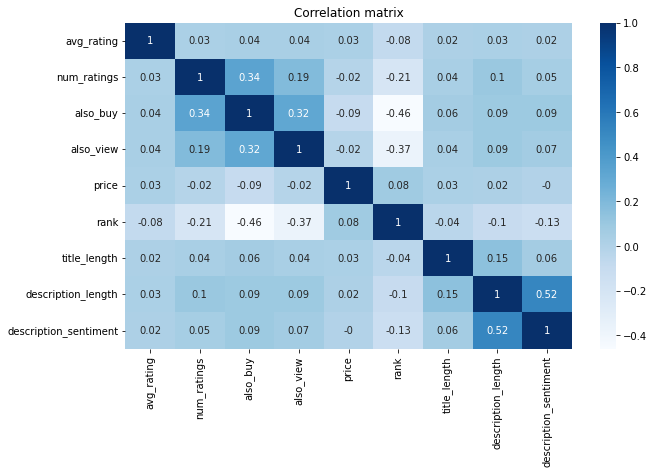

In [103]:
# load data
category = 'Candy & Chocolate' # define category  
df_train = pd.read_csv('data/'+category+'/df_train_sales.csv')

# get numeric features 
num_features = ['avg_rating','num_ratings','also_buy','also_view','price','rank','title_length','description_length','description_sentiment']

# plot correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(df_train[num_features].corr().round(2), cmap='Blues', annot=True).set_title('Correlation matrix')
plt.show()

Looking at sales rank, it is seen, that this variable is inversely correlated with "also_buy" and "also_view". 

This means that products that are selling well are often bought together with other products. This makes a lot of sense, since people tend to buy several items at a time when online shopping and especially when considering chocolate and candy products. Who will buy a single chocolate bar for 2,83 dollars (20 DKK) online? 

It also makes sense, that popular products have a longer list of also viewed products. When a product is bought, it is also viewed and thus Amason is able to get more data on products that the customer have viewed during the same shopping. 

Rank is also inversely correlated with the number of ratings. However, since customers are only allowed to rate products after buying, this correlation just tells us that product that sells a lot have more ratings. This is not that interesting and thus we choose not to include the number of ratings in the later modeling of sales rank. 

Finally, we see that both description length and description sentiment is a bit inversely correlated with sales rank. Price, title length and average rating do not seem to have much affect on the sales rank.

Besides the correlation plot, we also want to look at the distribution of the description sentiment feature. 

In [104]:
df_train.description_sentiment.describe()

count    29819.000000
mean         0.632909
std          0.351258
min         -0.902200
25%          0.421500
50%          0.765000
75%          0.939300
max          0.999600
Name: description_sentiment, dtype: float64

The product descriptions are in general categorised as very positive. It is seen that 50% of the product descriptions are in the interval [0.42,0.94] which is a very high positive score. This is not surprising since it is the producers themselves who write the descriptions. Below we look at the product description of the product with the lowest sentiment score and the product with the highest sentiment score.

In [105]:
print('product description classified with sentiment score:', df_train['description_sentiment'].min(),':')
print('product id: ', (df_train[df_train['description_sentiment'] == df_train['description_sentiment'].min()]).iloc[0]['item'])
print('product description:', (df_train[df_train['description_sentiment'] == df_train['description_sentiment'].min()]).iloc[0]['description'])
print(' ')
print('product description classified with sentiment score:', df_train['description_sentiment'].max(),':')
print('product id: ', (df_train[df_train['description_sentiment'] == df_train['description_sentiment'].max()])['item'])
print('product description:', df_train[df_train['description_sentiment'] == df_train['description_sentiment'].max()]['description'].values)

product description classified with sentiment score: -0.9022 :
product id:  B00SZ8W5PW
product description: flavored lollipop strawberry grape blueberry orange contain real cricket ha suspended flavored confines sucker dont eat insect just defeat purpose having bug lollipop wouldnt lollipop sugarfree flavored syrup pack 4 individually wrapped sucker includes 1 strawberry 1 grape 1 blueberry 1 orange flavor contain soy sucker net weight 1 oz statement regarding dietary evaluated fda intended diagnose treat prevent disease health
 
product description classified with sentiment score: 0.9996 :
product id:  6447    B001UG7LRI
Name: item, dtype: object
product description: ['size 45 x 45 mm heart donut absolutely gorgeous powerful love talisman come genuine natural rose quartz gemstone increasing power love energy force nthe heart donut come precious pouch case wish unique love talisman gift special nthis gift remembered influence love spirit loved love donut talisman used pendant lucky pow

The product descriptions are not coherent due to the textpreprocessing where puncutations, stopwords etc. are removed. The first product description contains words as: suspended, dont, insect, defeat, bug, dietary, fda, diagnose, prevent and disease, while the second product description includes words as: absolutely, gorgeous, powerful, love, genuine, rose, energy, force, happy, positive, gentle, forgiveness, compassion etc. Hence looking at the words from the two product descriptions, it makes sense that the first product description is associated with a lot more negative energy than the second. 

Even though the description of product 'B00SZ8W5PW' is categorised as being negative, it may primarly be due to the last statement of the description regarding FDA. Below is the description of the product shown before the textprocessing. 

In [106]:
print(metadata_df[metadata_df['item']=='B00SZ8W5PW'].description.values)

['["These flavored lollipops (strawberry, grape, blueberry and orange) contain a real cricket that has been suspended within the flavored confines of the sucker. You don\'t have to eat the insect, but that would just defeat the purpose of having a bug in your lollipop, now wouldn\'t it? Each lollipop is made from a sugar-free, flavored syrup. Pack of 4 individually wrapped suckers includes 1 strawberry, 1 grape, 1 blueberry and 1 orange flavor. May contain soy. Each sucker net weight 1 oz.", \'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.\']']


### Train model 

We are now ready to fit a regression model with sales rank as response variable and average rating, also buy, also view, price, title length, description length and description sentiment as explanatory variables. We use the same training function "train_regression_models" as we used for the first analysis described in the section "Building regression models" to find the best regression model for our data. Furthermore, we tune model using the function "tune_model" also described in the section "Building regression models". 

In [39]:
# load data
category = 'Candy & Chocolate'
df_train = pd.read_csv('data/' + category + '/df_train_sales.csv')
df_test = pd.read_csv('data/' + category + '/df_test_sales.csv')
X_train = df_train.drop(columns=['description','title','num_ratings'])
X_test = df_test.drop(columns=['description','title','num_ratings'])
X_train = X_train.dropna()
X_test = X_test.dropna()
y_train = X_train['rank']
X_train = X_train.drop(columns='rank')
y_test = X_test['rank']
X_test = X_test.drop(columns='rank')

model, name = train_regression_models(X_train, X_test, y_train, y_test) # use function for training 7 regression models 
print('best default model: ', name)
#params, tuned_model = tune_model(model, name, X_train, y_train)

# Save tuned model
#today = date.today()
#filename = 'models/'+category+'/best_performing_model_sales_'+str(today)+'.sav'
#pickle.dump(tuned_model, open(filename, 'wb'))

----------------------
Linear Regression: 
MAE  0.04058086534299828
R2  0.27928330303336646
Explained variance  0.27935417770654103
----------------------
----------------------
XGBoost Regressor: 
MAE  0.0266067498946478
R2  0.6183567267590827
Explained variance  0.6184776112173314
----------------------
----------------------
CatBoost Regressor: 
MAE  0.02626851263124657
R2  0.6262813784084091
Explained variance  0.6263455881907547
----------------------
----------------------
Stochastic Gradient Descent Regression: 
MAE  0.040393924119783084
R2  0.2767981973125079
Explained variance  0.27704693521127766
----------------------
----------------------
Elastic Net Regression: 
MAE  0.04925644877979877
R2  -0.0001195070918282859
Explained variance  -2.220446049250313e-16
----------------------
----------------------
Bayesian Ridge Regression: 
MAE  0.04058266311427272
R2  0.2792234615707506
Explained variance  0.2792942379755351
----------------------
----------------------
Gradient Boos

The best model after running the function "train_regression_models" is a catboost regressor. We use the "tune_model" function to tune the hyperparameters depth and learning rate of the catboost regressor. The tuned model is saved, such that we do not have to run the cumbersome tuning again. 

### Interpretability 

After tuning the model, we want to interpret the model in order to investigate how the features affect the sales rank. We start by computing the shap values of test set and do a shap summary plots. 

MAE of the best model:  0.02582599310206341


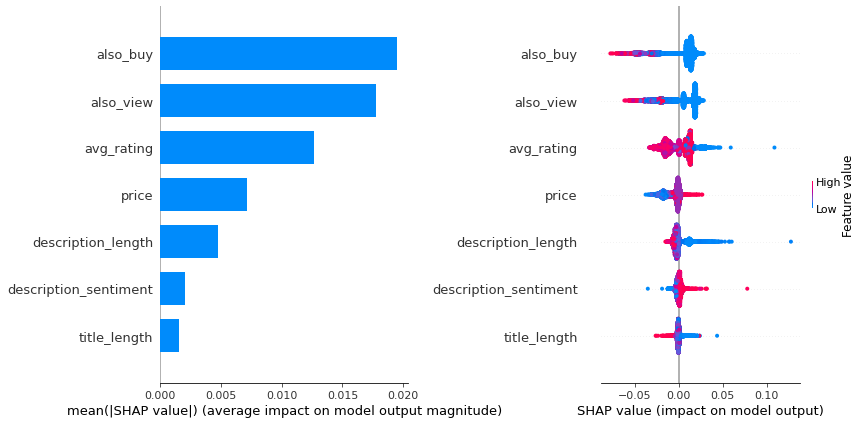

In [107]:
# load model and data used for modeling
category = 'Candy & Chocolate' # get category 
today = date.today()
model = pd.read_pickle('models/'+category+'/best_performing_model_sales_2022-05-07.sav') # load best model 

# get features and response
df_train = pd.read_csv('data/' + category + '/df_train_sales.csv')
df_test = pd.read_csv('data/' + category + '/df_test_sales.csv')
X_train = df_train.drop(columns=['item','description','title','num_ratings'])
X_test = df_test.drop(columns=['item','description','title','num_ratings'])
X_train = df_train
X_train = X_train.dropna()
X_test = X_test.dropna()
y_train = X_train['rank']
X_train = X_train.drop(columns='rank')
y_test = X_test['rank']
X_test = X_test.drop(columns='rank')

# MAE 
preds = model.predict(X_test)
print('MAE of the best model: ', mean_absolute_error(y_test, preds))

# Get shap values 
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(X_test)
shap_values_pandas = pd.DataFrame(shap_values)

# shap summary plots
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False, plot_size=None)
plt.subplot(1,2,2)
shap.summary_plot(shap_values, X_test, show=False, plot_size=None)
plt.tight_layout()
plt.show()

The above figures shows a summary plot of how the different features affect the prediction of sales rank. The right summary plot shows how the features impact the predictions and the left plot shows how the features impact the predictions in magnitude. 

At the left plot, it is seen that "also_buy" and "also_view" are the features affecting the prediction of sales rank the most. Looking at the right plot, it is seen that low values of "also_buy" and "also_view" are increasing the prediction of sales rank, i.e predicting a product that sells worse. This is in correspondance with the correlation matrix, where we saw that sales rank is inversely correlated with both "also_buy" and "also_view". 

Looking at the average rating, the right summary plot shows that a high average rating lowers the prediction of the sales rank which also makes a lot of sense - high rated products will be bought more. 

Regarding the price, the shap values tell that a high price for candy and chocolate make the product less sellable. It is difficult to recommend Amason to lower the prices of their candy and chocolate products, however our model shows that sale periods may be a good idea. 

Regarding description length, description sentiment and title length, the output is very interesting. Even though the importance of these three features are not large, the distribution of low and high values at the right summary plot is very clear. The right summary plot shows that a short product description gives a higher prediction of the sales rank, meaning that products that sell less tend to have shorter descriptions. The same tendency holds for the title length, however description length has stronger impact. When looking at the description sentiment, it is seen that high values, meaning a very positive description will give predictions of the prodcut being selling less. This seems weird at first - how can a positive description be a bad thing? Let's investigate this further with a partial dependence plot. 

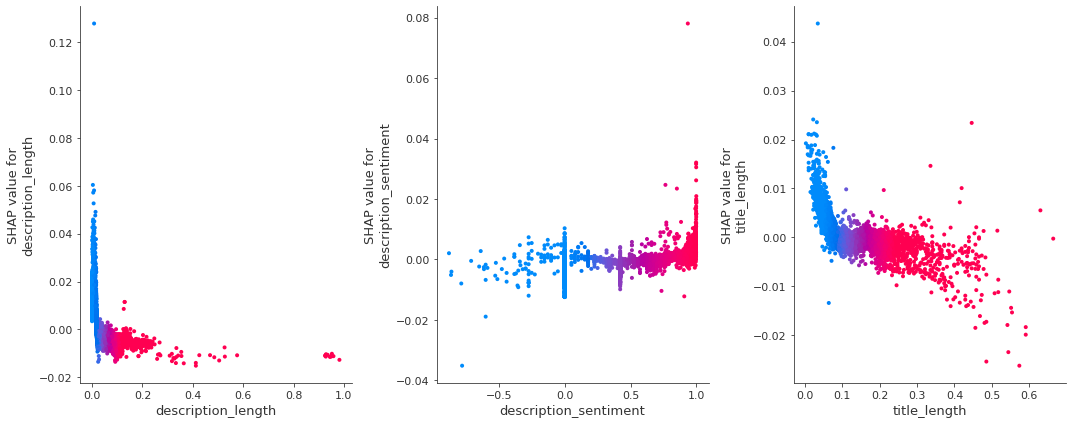

In [108]:
# shap dependence plots 
fig, axes = plt.subplots(1,3,figsize=(15,6))
shap.dependence_plot(ind='description_length', interaction_index='description_length',shap_values=shap_values, features=X_test, show=False, ax = axes[0])
shap.dependence_plot(ind='description_sentiment', interaction_index='description_sentiment',shap_values=shap_values, features=X_test, show=False, ax = axes[1])
shap.dependence_plot(ind='title_length', interaction_index='title_length',shap_values=shap_values, features=X_test, show=False, ax=axes[2])
plt.tight_layout()
plt.show()

The above figure shows a partial dependence plot of the description length, description sentiment and the interaction between these two features. When looking at the partial depence plot of the description length, it is seen that it is none or very short descriptions that pulls the sales rank upwards. When the description length reaches a certain level (around 0.2 in the transformed domain), the effect on sales rank seem to stagnate.

The partial dependence plot of sentiment analysis shows that descriptions can decrease the sales rank a bit if they are catgorised as neutral or negative. Thinking of the most negative description from the training set which we investigated in the exploratory analysis, this was mainly categorised as negative due to the statement about fda. Thus we might not be able to conluce that it is a good thing when the parts of the description reffering directly to the product has negative sentiment. But we can conclude that very positive over-excited descriptions are not popular and tend to give predictions of larger sales ranks.  

Finally, the partial dependence plot of the title length shows that the longer title length the better which was the same affect seen at the shap summary plot. 

In [111]:
# shap force plot
product_to_enhance_index = int(df_test[df_test['item']=='B00AEIR3HG'].index.values)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[product_to_enhance_index,:], X_test.iloc[product_to_enhance_index,:])

TypeError: only size-1 arrays can be converted to Python scalars

## Discussion and conclusion